## Testing aggregates on Seasonally Binned S82 light curves 

This notebook is mainly to test routine 

    process_patch_seasonally()

which is used to calculate aggregate metrics on seasonally-binned data 

### Standard imports 

In [1]:
import numpy as np
import pandas as pd 
import os
import sys
import datetime
from astropy.time import Time
from astropy.table import Table
from astropy.table import Column

path_to_home = '/Users/chris/GradResearch/'
sys.path.insert(0, path_to_home + 'SDSS_S82_FP_research/packages/')
pd.options.mode.chained_assignment = None

import faintFunctions as faintF 
import variabilityFunctions as varF
import imp
import processPatch2 as procP

### Testing the code on one filter-patch

The args and kwargs  : 

    process_patch_seasonally(name, DirIn, DirOut, pre='VarD_', 
    calc_sigma_pdf=False, limitNrows=None, verbose = None )

In [2]:
name = 'u00_21.csv'
DirIn = '/Users/chris/GradResearch/SDSS_S82_FP_research/raw_data/\
rawDataFPSplit/'
DirOut = '/Users/chris/GradResearch/SDSS_S82_FP_research/\
data_products/varMetrics/'
pre = 'VarD_'
calc_sigma_pdf = False
limitNrows = 1e5
verbose = None 

start with psfFlux , psfFluxErr,  and convert to Jansky, 
      remove all NaN or missing rows... 

In [3]:
print('\n Processing filter_patch file %s' % name)
    
# read in the raw lightcurve... 
# NOTE : if nrows = None , pd.read_csv() reads the entire file 
raw_data_df = pd.read_csv(DirIn+name+'.gz', compression='gzip',  
             usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'], 
             nrows=limitNrows )
raw_data = Table.from_pandas(raw_data_df)

##########  STEP 1 : single-epoch data ###########  
#         1 Jy = 1.0E-26 W/m^2/Hz = 1.0E-23 erg/s/cm^2/Hz
# 1.1  :  convert Flux from erg/cm2/sec/Hz  to Jansky
# make new columns with data in Jy, to follow good 
# programming practice (otherwise, changes are either
# on a view or a copy and it's not always clear)

raw_data['psfFluxJy'] = raw_data['psfFlux'] * 1E23 
raw_data['psfFluxErrJy'] = raw_data['psfFluxErr'] * 1E23 


# 1.2  : drop all rows which have NaNs in psfFlux .... 
m1  = np.isnan(raw_data['psfFlux'].data)  # true if NaN 
 # true if not finite... 
m2 = np.bitwise_not(np.isfinite(raw_data['psfFlux'].data))  


# logical or : true if either condition satisfied 
m = m1 | m2  

if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    print('In  file %s there are : \n.... %d rows where psfFlux \
        is NaN'%(name, np.sum(m1)))
    print('.... %d rows where psfFlux is not finite  '% np.sum(m2))
    print('All such rows are dropped')
    indices = np.arange(len(raw_data))
    remove_rows= indices[m]
    raw_data.remove_rows(remove_rows)

# 1.3 : check psfFluxErr : drop all rows which have NaN, or 0 ,
# to avoid getting error when calculating S/N  = psfFlux / psfFluxErr 

m1  = np.isnan(raw_data['psfFluxErr'].data)  # true if NaN 
# true if not finite... 
m2 =  np.bitwise_not(np.isfinite(raw_data['psfFluxErr'].data))  
m3 =  raw_data['psfFluxErr'].data == 0 
# logical or : true if either condition satisfied 
m = m1 | m2  | m3

if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    print('In  file %s there are : \n.... %d rows where psfFluxErr \
        is NaN'%(name, np.sum(m1)))
    print('.... %d rows where psfFluxErr is not finite'% np.sum(m2))
    print('.... %d rows where psfFluxErr = 0 '% np.sum(m3))
    print('All such rows are dropped')
    indices = np.arange(len(raw_data))
    remove_rows= indices[m]
    raw_data.remove_rows(remove_rows)


 Processing filter_patch file u00_21.csv


In [4]:
raw_data[:5]

objectId,mjd,psfFlux,psfFluxErr,psfFluxJy,psfFluxErrJy
int64,float64,float64,float64,float64,float64
216172782516437336,51819.3547092,2.96635973015e-29,1.00141030769e-29,2.96635973015e-06,1.00141030769e-06
216172782516437336,52522.3160904,-2.57309296039e-30,9.60874836566e-30,-2.57309296039e-07,9.60874836566e-07
216172782516437336,52552.3115881,-2.57873134338e-30,1.19206364848e-29,-2.57873134338e-07,1.19206364848e-06
216172782516437336,52558.3198825,2.58962936179e-29,1.02984796939e-29,2.58962936179e-06,1.02984796939e-06
216172782516437336,52577.2076585,1.09094753294e-29,7.28209215822e-30,1.09094753294e-06,7.28209215822e-07


aggregate by objectId, and within each aggregate,  define 
    in which season is each epochal forced photometry measurement 

In [5]:
# make a new column to designate seasons...
raw_data['season'] = np.nan

In [6]:
# I make a list of boundaries between season start / end : season_bounds
# first it's a list with 2005-08-01 , 2006-08-01, etc...
season_bounds = [str(year)+'-08-01 00:00:00.000' for year in np.arange(2005,2009)]
# Then I insert a very early date at the beginning of the list, 
season_bounds.insert(0,'1990-08-01 00:00:00.000' )
# so that all epochs between
# 1990 and 2005 are clustered together.
# Thus 1990-08-01 - 2005-08-01  is Season1
# 2005-2006  : Season2 ;  2006-2007 : Season3, etc.  
# All photometry is averaged within each Season. 

# Use AstroPy Time module
cutDates = Time(season_bounds, format='iso')

seasons = np.arange(len(cutDates))+0 

In [15]:
# Assign value of a season for each row...
for i in range(len(cutDates.mjd)-1):
    mask = (raw_data['mjd'].data > cutDates[i].mjd) * \
           (raw_data['mjd'].data < cutDates[i+1].mjd)
    raw_data['season'][mask]  = seasons[i]  
    # this is better than raw_data[mask]['season'] : 
    # somehow the order  matters 

In [16]:
raw_data['season'].data

array([ 0.,  0.,  0., ...,  3.,  3.,  3.])

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


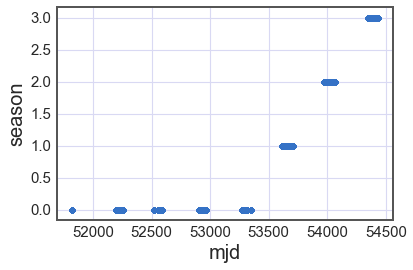

In [20]:
%matplotlib inline
# plot illustration of how mjd's are grouped into seasons...
import matplotlib.pyplot as plt
# Generic plot settings...
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20

fig,ax = plt.subplots()
ax.scatter( raw_data['mjd'].data, np.array(raw_data['season'].data).astype(int))
ax.set_xlabel('mjd')
ax.set_ylabel('season')
plt.savefig('test.png')

In [21]:
# At the moment, it is impossible to apply complicated 
# functions to groupby objects....
# Easier at this point to just convert AstroPy table 
# to Pandas,  and do it from here on in Pandas ...
# Bummer. 

# But thankfully it only takes a few seconds 
# even on mac,  on the full patch  file 
raw_data_df = raw_data.to_pandas()

# calculate seasonal averages 
grouped = raw_data_df.groupby(['objectId','season'])

In [27]:
imp.reload(varF)

<module 'variabilityFunctions' from '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/variabilityFunctions.py'>

In [104]:
#seasonal_averages

In [29]:
seasonal_averages= grouped.apply(varF.computeVarMetrics, 
                                 flux_column='psfFluxJy',
                                 error_column = 'psfFluxErrJy',
                                 time_column = 'mjd', 
                                 calc_sigma_pdf = False, 
                                 verbose=False,
                                 seasonal_average = True)

In [79]:
# Calculate S/N : first using mean, and then median, and in each case if they
# are below 2,  replace by faintMean, faintMedian, faintRMS 

# read in the lookup interpolation table, 
# which makes it very fast thanks to the 
# smoothness of functions used  
table_address = 'flat_prior_const_counts_lookup.csv'
lookup = Table.read(table_address)


# 1.5  calculate faint quantities for all rows  where S/N < 2 
for avg_method in ['Mean', 'Median']:
    S = seasonal_averages['psfFlux'+avg_method].values
    N = seasonal_averages['psfFlux'+avg_method+'Err'].values
    SN = S/N
    mask_SN = SN < 2 
    seasonal_averages['flagFaint'+avg_method] = mask_SN
    print('There are %d seasons of %d that have %s-based  S/N < 2' %(np.sum(mask_SN),\
        len(mask_SN), avg_method))

    # interpolate at the xObs = SN  locations .... 
    faint_SN = SN[mask_SN]
    xMean =  np.interp(faint_SN, lookup['xObs'].data, lookup['xMean'].data)
    xMed =  np.interp(faint_SN,lookup['xObs'].data, lookup['xMedian'].data)
    xSigma =  np.interp(faint_SN,lookup['xObs'].data,lookup['xSigma'].data)
    xRMS = np.interp(faint_SN, lookup['xObs'].data, lookup['xRMS'].data)

    faintMean = xMean * N[mask_SN]
    faintRMS = xRMS * N[mask_SN]

    # Not sure if need to save these values for anything ... can always do it later,
    # but for now we just replace the Signal  by faintMean , 
    # and Noise by faintRMS 
    seasonal_averages['psfFlux'+avg_method][mask_SN] = faintMean
    seasonal_averages['psfFlux'+avg_method+'Err'][mask_SN] = faintRMS

There are 0 seasons of 5377 that have Mean-based  S/N < 2
There are 0 seasons of 5377 that have Median-based  S/N < 2


In [81]:
#

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


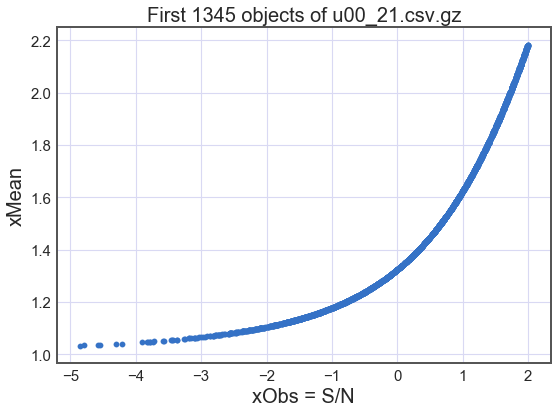

In [71]:
# Just to prove that everything works just fine ... 
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(SN[mask_SN], faintMean/ N[mask_SN])
ax.set_xlabel('xObs = S/N')
ax.set_ylabel('xMean')
ax.set_title('First '+str(len(np.unique(raw_data['objectId']))) + \
             ' objects of u00_21.csv.gz')
plt.savefig('test_seasonally_binned_faint_pipeline1.png', bbox_inches='tight')

In [117]:
seasonal_averages.index.levels[0]

Int64Index([216172782516437336, 216172782516437339, 216172782516437345,
            216172782516437346, 216172782516437358, 216172782516437360,
            216172782516437362, 216172782516437371, 216172782516437379,
            216172782516437381,
            ...
            216172783590182804, 216172783590182830, 216172783590182833,
            216172783590182867, 216172783590182886, 216172783590182898,
            216172783590182905, 216172783590182910, 216172783590182920,
            216172783590182954],
           dtype='int64', name='objectId', length=1345)

In [102]:
# Calculate seasonal magnitudes 
for avg_method in ['Mean', 'Median'] : 
    flux = 'psfFlux'+avg_method
    flux_err = 'psfFlux'+avg_method+'Err'
    mag = 'psf'+avg_method
    mag_err = 'psf'+avg_method+'Err' 
    
    seasonal_averages[mag]= \
        procP.flux2ab(seasonal_averages[flux], unit='Jy')    
    seasonal_averages[mag_err] = \
        procP.flux2absigma(seasonal_averages[flux], seasonal_averages[flux_err])    
    
    # Wherever the error in magnitudes is smaller than the minimum value, 
    # add that minimum value

    e = seasonal_averages[mag_err].values
    # How many seasons have Mean Err < min_err ? 
    min_err = 0.003
    mask_err = e < min_err
    print('Number of seasons with error < %.3f is %d'%(min_err,np.sum(mask_err)))
    e_new = np.sqrt(min_err + e[mask_err])

    f = seasonal_averages[flux][mask_err]
    fErr =  seasonal_averages[flux_err][mask_err]
    fErrNew = np.sqrt(fErr**2.0 + (min_err * f)**2.0)

    seasonal_averages[flux_err][mask_err] = fErrNew



Number of seasons with error < 0.003 is 8
Number of seasons with error < 0.003 is 0


In [120]:
# need to change the multindex to columns, to be able to aggregate again...
# https://stackoverflow.com/questions/20110170/turn-pandas-multi-index-into-column 
seasonal_averages.reset_index(inplace=True)  

#### Save the seasonal averages HERE ! 

In [123]:
seasonal_averages[:10]

,objectId,season,N,chi2DOF,chi2R,flagLtTenPts,maxMJD,meanMJD,meanSN,minMJD,...,psfFluxSigG,psfFluxSkew,psfFluxStDev,flagFaint,flagFaintMean,flagFaintMedian,psfMean,psfMeanErr,psfMedian,psfMedianErr
0,216172782516437336,0.0,13.0,2.449688,1.541985,NaN,53352.112576,52767.698502,1.279859,51819.354709,...,1.126948e-06,0.0,1.180163e-06,False,False,False,23.903949,0.237600,23.749627,0.258332
1,216172782516437336,1.0,20.0,1.528823,0.869733,NaN,53705.212024,53666.262256,1.115632,53622.320880,...,1.380788e-06,0.0,1.466114e-06,False,False,False,23.547062,0.213652,23.504472,0.257473
2,216172782516437336,2.0,20.0,1.319656,0.908277,NaN,54068.218192,54027.121269,0.973769,53975.296819,...,1.139126e-06,0.0,1.357195e-06,False,False,False,23.658872,0.244193,23.591663,0.287681
3,216172782516437336,3.0,15.0,1.690726,0.727644,NaN,54422.234976,54395.610309,1.216188,54357.275736,...,1.478026e-06,0.0,1.358368e-06,False,False,False,23.564670,0.227112,23.809071,0.356501
4,216172782516437339,0.0,14.0,1.951810,1.110862,NaN,53352.112576,52777.883569,0.329167,51819.354709,...,7.040100e-07,0.0,1.023135e-06,True,False,False,25.217590,0.505499,24.981383,0.506356
5,216172782516437339,1.0,18.0,0.947346,0.694827,NaN,53705.212024,53665.430719,-0.120047,53622.320880,...,1.103142e-06,0.0,1.112617e-06,True,False,False,25.459248,0.540960,24.879385,0.526098
6,216172782516437339,2.0,21.0,1.568071,0.866963,NaN,54068.218192,54026.988690,0.177131,53975.296819,...,1.294525e-06,0.0,1.359208e-06,True,False,False,25.356777,0.534023,25.486133,0.499920
7,216172782516437339,3.0,17.0,1.060968,1.179825,NaN,54422.234976,54397.095459,0.335943,54357.275736,...,1.437758e-06,0.0,1.092188e-06,True,False,False,24.730772,0.513145,24.495912,0.515320
8,216172782516437345,0.0,13.0,1.601129,0.878055,NaN,53352.112576,52767.698374,-0.136317,51819.354709,...,7.797275e-07,0.0,8.966255e-07,True,False,False,25.988086,0.499933,25.621999,0.498116
9,216172782516437345,1.0,17.0,1.758758,1.593516,NaN,53705.212024,53666.029743,-0.228740,53622.320880,...,2.436486e-06,0.0,1.459337e-06,True,False,False,25.860138,0.502205,25.658635,0.502613


In [126]:
seasonal_averages.columns

Index(['objectId', 'season', 'N', 'chi2DOF', 'chi2R', 'flagLtTenPts', 'maxMJD',
       'meanMJD', 'meanSN', 'minMJD', 'psfFluxMean', 'psfFluxMeanErr',
       'psfFluxMedian', 'psfFluxMedianErr', 'psfFluxSigG', 'psfFluxSkew',
       'psfFluxStDev', 'flagFaint', 'flagFaintMean', 'flagFaintMedian',
       'psfMean', 'psfMeanErr', 'psfMedian', 'psfMedianErr'],
      dtype='object')

In [127]:
# 3a) Aggregate by objectId
grouped = seasonal_averages.groupby('objectId')

# calculate stats using seasonal averages... 
# do it only using Mean... 
# next time around can also do that using Median, and 
# hstack the two ... 
varMetricsSeasons  = grouped.apply(varF.computeVarMetrics, 
                                 flux_column='psfFluxMean',
                                 error_column = 'psfFluxMeanErr',
                                 time_column = 'meanMJD', 
                                 calc_sigma_pdf = False, 
                                 verbose=False,
                                 seasonal_average = False)

In [129]:
# need to rename the columns to reflect the fact that we used seasonal Mean-based averages,
# as opposed to Median-based averages 

# calculate magnitudes for full light curve aggregates based on seasonal averages 
varMetricsSeasons['psfMean'] = procP.flux2ab(varMetricsSeasons['psfFluxMean'], 
                                                unit='Jy')
varMetricsSeasons['psfMeanErr'] = procP.flux2absigma(varMetricsSeasons['psfFluxMean'], 
                                                     varMetricsSeasons['psfFluxMeanErr'])    

In [130]:
#### Save the full LC Metrics based on averaged seasons .... 


Note to self  : return to parts marked by ### ! 